# 3. Napovedovanje aktivnosti struktur na naboru naključnih molekul

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon

In [2]:
directory = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved'
filepath_train_data = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/molekulski_prstni_odtisi/df_circular.csv'

# Pridobitev naključnih struktur

In [3]:
import modin.pandas as pdm
df = pdm.read_csv('/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved/df_with_fingerprints.csv')

# Read the training dataset
df_train = pdm.read_csv(filepath_train_data)

# Extract SMILES strings from the training dataset
trained_smiles = set(df_train['Smiles'])


# Filter out rows that are in the training dataset
df_filtered = df[~df['Smiles'].isin(trained_smiles)]


# Calculate the count of matches excluded
matches_count = len(df) - len(df_filtered)
print(f'Number of matches excluded: {matches_count}')


# df_filtered = df_filtered.sample(n=1000000, random_state=kon.random_seed)
df_filtered

2024-12-23 12:35:04,314	INFO worker.py:1819 -- Started a local Ray instance.
(raylet) Spilled 3316 MiB, 12 objects, write throughput 1511 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 7262 MiB, 25 objects, write throughput 2229 MiB/s.
(raylet) Spilled 33123 MiB, 114 objects, write throughput 2839 MiB/s. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(raylet) Spilled 66848 MiB, 407 objects, write throughput 2574 MiB/s.


Number of matches excluded: 101


,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
0,O=C1N(Cc2ccc(s2)S(=O)(=O)N2CCCc3ccccc23)C(=O)c...,Molport-007-763-075,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Cc1ccccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C2=O)s1,Molport-007-763-076,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,COc1cc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,Molport-007-763-077,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cc1c(Cl)cccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C...,Molport-007-763-078,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cc1ccc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,Molport-007-763-079,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5318939,Clc1ccc(cc1)-n1c(nc2n(ncc2c1=O)-c1ccccc1)-c1cccs1,Molport-002-191-019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5318940,Cc1cc(Cl)cc(Cl)c1OCC(=O)Nc1ccc(O)c(c1)-c1nc2cc...,Molport-002-191-020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5318941,CCOC(=O)C1=C(Nc2ccc(cc2)[N+]([O-])=O)S\C(=C/c2...,Molport-002-191-021,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5318942,COc1ccc(cc1)-n1nc2ccc(NC(=O)Cc3ccc(Cl)cc3)cc2n1,Molport-002-191-022,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(raylet) Spilled 131433 MiB, 629 objects, write throughput 566 MiB/s.


In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.decomposition import PCA
from joblib import Parallel, delayed

# Prepare the target variable (y) and features (X)
y = df_train['Activity'].values.ravel()  # Assuming 'Activity' is the target
X = df_train.iloc[:, 3:]  # Assuming features start from the 4th column

# Step 1: Remove features with no variance
var_threshold = VarianceThreshold(threshold=0)  # Remove features with variance = 0
X = var_threshold.fit_transform(X)

svc_params = {
    'C': 0.5282295441556119,
    'kernel': 'rbf',
    'gamma': 'scale'
}

# Define the pipeline steps
steps = [
    ('feature_selection', SelectKBest(score_func=chi2, k=726)),  # Using k=726 as specified
    ('sampling', RandomUnderSampler(random_state=kon.random_seed)),  # Adjust sampling method as needed
    ('classifier', SVC(probability=True, random_state=kon.random_seed, **svc_params))  # Apply the SVC parameters
]

# Initialize the pipeline
pipeline = ImbPipeline(steps)

# Step 2: Train the model on the entire training dataset
pipeline.fit(X, y)

# Step 3: Load the new dataset (e.g., test dataset)
df_molport = df_filtered  # Assuming df_filtered is your new dataset

# Prepare the features from the new dataset
X_molport = df_molport.iloc[:, 2:]  # Assuming the same feature structure as the training dataset

# Step 4: Remove features with no variance from the new dataset
X_molport = var_threshold.transform(X_molport)

# Step 5: Make predictions on the new dataset using parallel processing
def make_predictions(model, data):
    return model.predict(data), model.predict_proba(data)



# Assuming 'pipeline' is your trained model and 'X_molport' is your new dataset
# Make predictions on the new dataset using batch processing
y_pred, y_proba = make_predictions_in_batches(pipeline, X_molport, num_chunks=6)

# Add the predicted activity and probability of being active (1) directly to df_molport
df_molport['Predicted_Activity'] = y_pred
df_molport['Probability_Active'] = y_proba[:, 1]  # Probability of being active (1)

# Display the relevant columns
result_df = df_molport[['Smiles', 'Predicted_Activity', 'Probability_Active']]
result_df

,Smiles,Predicted_Activity,Probability_Active
0,O=C1N(Cc2ccc(s2)S(=O)(=O)N2CCCc3ccccc23)C(=O)c...,0,0.244776
1,Cc1ccccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C2=O)s1,0,0.271395
2,COc1cc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,0,0.296264
3,Cc1c(Cl)cccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C...,0,0.288498
4,Cc1ccc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,0,0.472107
...,...,...,...
5318939,Clc1ccc(cc1)-n1c(nc2n(ncc2c1=O)-c1ccccc1)-c1cccs1,0,0.111392
5318940,Cc1cc(Cl)cc(Cl)c1OCC(=O)Nc1ccc(O)c(c1)-c1nc2cc...,0,0.268101
5318941,CCOC(=O)C1=C(Nc2ccc(cc2)[N+]([O-])=O)S\C(=C/c2...,0,0.292229
5318942,COc1ccc(cc1)-n1nc2ccc(NC(=O)Cc3ccc(Cl)cc3)cc2n1,0,0.270213


In [6]:
result_df

,Smiles,Predicted_Activity,Probability_Active
0,O=C1N(Cc2ccc(s2)S(=O)(=O)N2CCCc3ccccc23)C(=O)c...,0,0.244776
1,Cc1ccccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C2=O)s1,0,0.271395
2,COc1cc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,0,0.296264
3,Cc1c(Cl)cccc1NS(=O)(=O)c1ccc(CN2C(=O)c3cccnc3C...,0,0.288498
4,Cc1ccc(NS(=O)(=O)c2ccc(CN3C(=O)c4cccnc4C3=O)s2...,0,0.472107
...,...,...,...
5318939,Clc1ccc(cc1)-n1c(nc2n(ncc2c1=O)-c1ccccc1)-c1cccs1,0,0.111392
5318940,Cc1cc(Cl)cc(Cl)c1OCC(=O)Nc1ccc(O)c(c1)-c1nc2cc...,0,0.268101
5318941,CCOC(=O)C1=C(Nc2ccc(cc2)[N+]([O-])=O)S\C(=C/c2...,0,0.292229
5318942,COc1ccc(cc1)-n1nc2ccc(NC(=O)Cc3ccc(Cl)cc3)cc2n1,0,0.270213


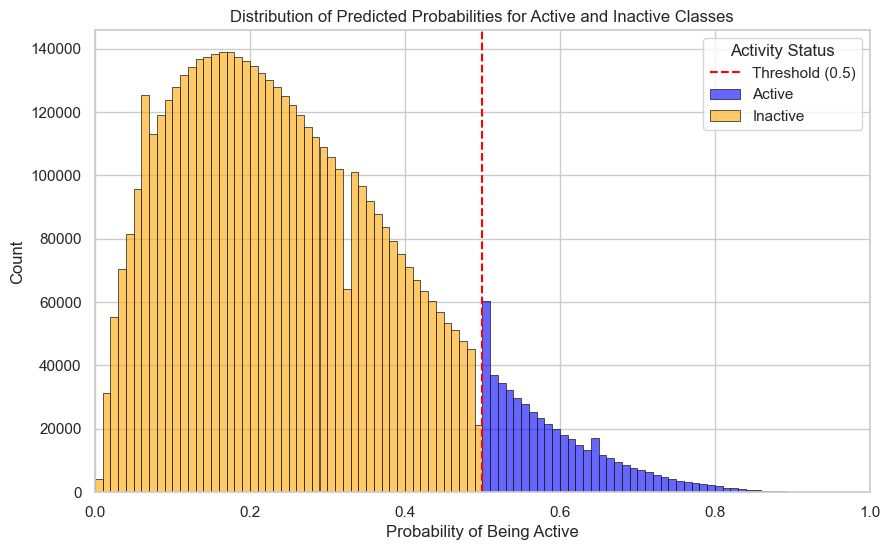

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming result_df is already defined with 'Predicted_Activity' and 'Probability_Active'

# Create a new column for the activity status based on Probability_Active
result_df['Activity_Status'] = np.where(result_df['Probability_Active'] >= 0.5, 'Active', 'Inactive')

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Define bins for 1% increments from 0 to 1
bins = np.arange(0, 1.01, 0.01)  # 0 to 1 in steps of 0.01

# Create the histogram for Active substances
sns.histplot(data=result_df[result_df['Activity_Status'] == 'Active'], 
             x='Probability_Active', bins=bins, 
             color='blue', stat='count', edgecolor='k', label='Active', alpha=0.6)

# Create the histogram for Inactive substances
sns.histplot(data=result_df[result_df['Activity_Status'] == 'Inactive'], 
             x='Probability_Active', bins=bins, 
             color='orange', stat='count', edgecolor='k', label='Inactive', alpha=0.6)

# Add a vertical line at the 0.5 threshold for clarity
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')

# Add labels and title
plt.title('Distribution of Predicted Probabilities for Active and Inactive Classes')
plt.xlabel('Probability of Being Active')
plt.ylabel('Count')
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
plt.grid(True)
plt.legend(title='Activity Status')

# Show the plot
plt.show()

In [8]:
# Count the number of active predictions above specified thresholds
thresholds = [0.5, 0.75, 0.9]

# Initialize a dictionary to store counts
active_counts = {}

for threshold in thresholds:
    count_active = result_df[result_df['Probability_Active'] > threshold]['Predicted_Activity'].value_counts().get(1, 0)
    active_counts[f'Count_Active_Above_{int(threshold * 100)}%'] = count_active

# Display the counts
active_counts_df = pd.DataFrame(active_counts, index=[0])
print(active_counts_df)


the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


   Count_Active_Above_50%  Count_Active_Above_75%  Count_Active_Above_90%
0                  450039                   22731                     257


In [9]:
# Filter for active predictions (Predicted_Activity == 1) and sort by Probability_Active in descending order
active_results = df_molport[df_molport['Predicted_Activity'] == 1].sort_values(by='Probability_Active', ascending=False)
active_results

,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Predicted_Activity,Probability_Active
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.975293
3953052,C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-046-934-999,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.964400
3926967,C[C@@H](NC(=O)c1ccc(F)cc1)c1ccc2N(CCc2c1)C(=O)...,Molport-046-836-530,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.963078
3783535,CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1...,Molport-046-416-773,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.959935
4219132,C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-047-588-443,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.956517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371602,CC1CCc2c(C1)sc1nc(C3CC3)n3c(SCC(=O)NNC(=O)C4CC...,Molport-000-074-702,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.479350
1160294,Oc1nc(Cn2cncn2)ncc1C(=O)NCc1ccccc1-n1cccn1,Molport-027-831-860,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.479349
39865,CCc1ccc(CNC(=O)c2ccc(NC(=O)c3nnc(COc4ccc(OC)c(...,Molport-007-815-918,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.479349
5188018,CS(=O)(=O)N(CC(=O)NCc1ccc2OCOc2c1)c1ccc(F)cc1,Molport-002-011-812,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.479349


In [10]:
active_results.head(100)

,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Predicted_Activity,Probability_Active
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.975293
3953052,C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-046-934-999,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.964400
3926967,C[C@@H](NC(=O)c1ccc(F)cc1)c1ccc2N(CCc2c1)C(=O)...,Molport-046-836-530,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.963078
3783535,CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1...,Molport-046-416-773,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.959935
4219132,C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-047-588-443,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.956517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525207,CCC(C)NC(=O)N1CCCC1c1nnc(s1)C(=O)Nc1ccc(F)c(F)c1,Molport-010-827-545,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.915277
149766,CC(C)C(NC(=O)Nc1ccc(Br)cc1)C(=O)N1CCc2ccccc12,Molport-007-964-652,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.915115
488587,Cc1cc(C)c(c(C)c1)S(=O)(=O)N1CCCC(C1)c1nnc(s1)C...,Molport-010-781-425,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.915067
1615790,Fc1ccc(Cl)cc1C(=O)Nc1ccc(nc1)N1CCN(C2CCCC2)C1=O,Molport-010-946-164,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0.915025


In [11]:
most_active = active_results.iloc[:2000].copy()
most_active

,Smiles,MOLPORTID,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,...,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Predicted_Activity,Probability_Active
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.975293
3953052,C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-046-934-999,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.964400
3926967,C[C@@H](NC(=O)c1ccc(F)cc1)c1ccc2N(CCc2c1)C(=O)...,Molport-046-836-530,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.963078
3783535,CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1...,Molport-046-416-773,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.959935
4219132,C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-047-588-443,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0.956517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040523,Cl.CC(C)c1ccc(cc1)-n1ncc(C(=O)Nc2ccc(F)c(c2)[N...,Molport-047-128-147,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.852980
2986643,CN(C1CCCCC1)S(=O)(=O)c1ccc(cc1)C(=O)Nc1nc-2c(C...,Molport-003-060-064,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.852979
3062375,CC1CCc2nc(NC(=O)c3cccc(NS(=O)(=O)c4ccc(F)cc4)c...,Molport-003-143-464,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0.852957
5031086,CC(C)NC(=O)C[C@@H]1c2nc(NC(=O)c3cccc(F)c3)sc2C...,Molport-001-754-097,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.852888


In [12]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog

def is_pains(smiles):
    mol = Chem.MolFromSmiles(smiles)
    
    # Initialize PAINS filter catalog
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
    catalog = FilterCatalog.FilterCatalog(params)
    
    # Check for PAINS
    entry = catalog.GetFirstMatch(mol)
    return 1 if entry is not None else 0

# Apply the PAINS filter function to the 'Smiles' column
most_active['is_pains'] = most_active['Smiles'].apply(is_pains)

# Filter out PAINS molecules
df_filtered_1 = most_active[most_active['is_pains'] == 0].drop(columns=['is_pains'])

most_active_filtered = df_filtered_1[['Smiles', 'MOLPORTID', 'Predicted_Activity', 'Probability_Active']].copy()
most_active_filtered

,Smiles,MOLPORTID,Predicted_Activity,Probability_Active
2007716,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,Molport-047-919-460,1,0.975293
3953052,C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-046-934-999,1,0.964400
3926967,C[C@@H](NC(=O)c1ccc(F)cc1)c1ccc2N(CCc2c1)C(=O)...,Molport-046-836-530,1,0.963078
3783535,CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1...,Molport-046-416-773,1,0.959935
4219132,C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(...,Molport-047-588-443,1,0.956517
...,...,...,...,...
4040523,Cl.CC(C)c1ccc(cc1)-n1ncc(C(=O)Nc2ccc(F)c(c2)[N...,Molport-047-128-147,1,0.852980
2986643,CN(C1CCCCC1)S(=O)(=O)c1ccc(cc1)C(=O)Nc1nc-2c(C...,Molport-003-060-064,1,0.852979
3062375,CC1CCc2nc(NC(=O)c3cccc(NS(=O)(=O)c4ccc(F)cc4)c...,Molport-003-143-464,1,0.852957
5031086,CC(C)NC(=O)C[C@@H]1c2nc(NC(=O)c3cccc(F)c3)sc2C...,Molport-001-754-097,1,0.852888


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


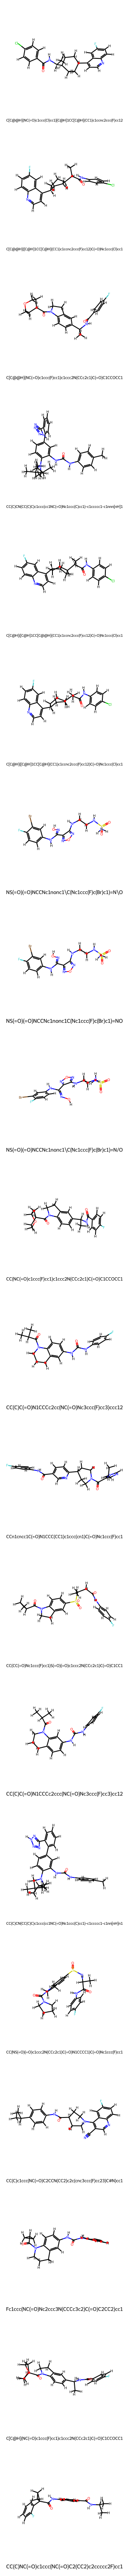

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Select the first five SMILES and convert to a list
smiles_list = most_active_filtered['Smiles'].head(20).tolist()

# Convert SMILES to RDKit Mol objects and generate 3D structures
molecules = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Add hydrogens
        mol = Chem.AddHs(mol)
        # Generate 3D coordinates
        AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
        AllChem.UFFOptimizeMolecule(mol)
        molecules.append(mol)

# Draw the molecules with SMILES as labels in separate rows
img = Draw.MolsToGridImage(molecules, molsPerRow=1, subImgSize=(300, 300), legends=smiles_list)

# Display the image
img

In [14]:
# Print out the first 20 SMILES
print("First 20 SMILES:")
for smiles in smiles_list:
    print(smiles)

First 20 SMILES:
C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12
C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
C[C@@H](NC(=O)c1ccc(F)cc1)c1ccc2N(CCc2c1)C(=O)C1CCOCC1
CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1ccccc1-c1nnn[nH]1
C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
C[C@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O
NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO
NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O
CC(NC(=O)c1ccc(F)cc1)c1ccc2N(CCc2c1)C(=O)C1CCOCC1
CC(C)C(=O)N1CCCc2cc(NC(=O)Nc3ccc(F)cc3)ccc12
CCn1cncc1C(=O)N1CCC(CC1)c1ccc(cn1)C(=O)Nc1ccc(F)cc1
CC(CC(=O)Nc1ccc(F)cc1)S(=O)(=O)c1ccc2N(CCc2c1)C(=O)C1CC1
CC(C)C(=O)N1CCCc2ccc(NC(=O)Nc3ccc(F)cc3)cc12
CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1ccccc1-c1nn[nH]n1
CC(NS(=O)(=O)c1ccc2N(CCc2c1)C(=O)N1CCCC1)C(=O)Nc1ccc(F)cc1
CC(C)c1ccc(NC(=O)C2CCN(CC2)c2c(cnc3ccc(F)cc23)C#N)cc1
Fc1ccc(NC(=O)Nc2ccc3N(CCCc3c2)C(=O)C2CC2)cc1
C[C@H]

In [15]:
df_filtered_1.to_csv('/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved/most_active_filtered_svm.csv', index=False)